In [2]:
from models import MeshModel, IcosphereModel
from models.mesh_transform import transform
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from geometry import clip, polygon_area
from geometry.utils import wrap
from jax.typing import ArrayLike
import jax

from jax import config
config.update("jax_enable_x64", True)

sol_rad = u.solRad.to(u.cm)

m1 = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))
m2 = transform(IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)])), sol_rad)

In [3]:
def visible_area(vertices1: ArrayLike, vertices2: ArrayLike) -> ArrayLike:
    clipped = jnp.nan_to_num(clip(vertices1, vertices2))
    return polygon_area(clipped[:, 0], clipped[:, 1])

total_visible_area = jax.jit(jax.vmap(visible_area, in_axes=(None, 0)))
visibility_areas = jax.jit(jax.vmap(total_visible_area, in_axes=(0, None)))

In [10]:
vs1 = m1.vertices[m1.faces[m1.mus>0].astype(int)]
vs2 = m2.vertices[m2.faces[m2.mus>0].astype(int)]
projected_areas = jax.jit(jax.vmap(polygon_area))
pa = projected_areas(vs1[:, :, 0], vs1[:, :, 2])
occluded = visibility_areas(vs1[:, :, [0, 2]], vs2[:, :, [0, 2]])

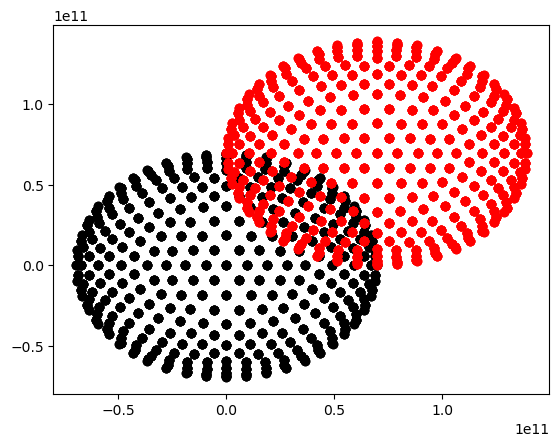

In [11]:
plt.scatter(vs1[:, :, 0], vs1[:, :, 2], c='black')
plt.scatter(vs2[:, :, 0], vs2[:, :, 2], c='red')

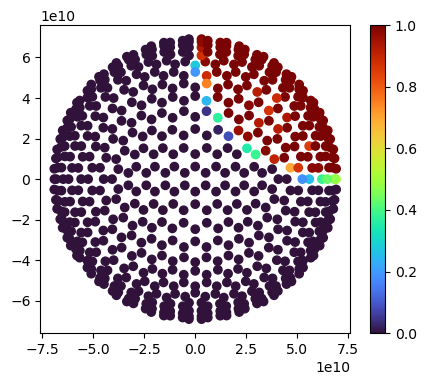

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
p1 = ax.scatter(m1.centers[m1.mus>0, 0], m1.centers[m1.mus>0, 2], c=jnp.clip(jnp.sum(occluded, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1), cmap='turbo')
plt.colorbar(p1, ax=ax)

(-100000000000.0, 100000000000.0)

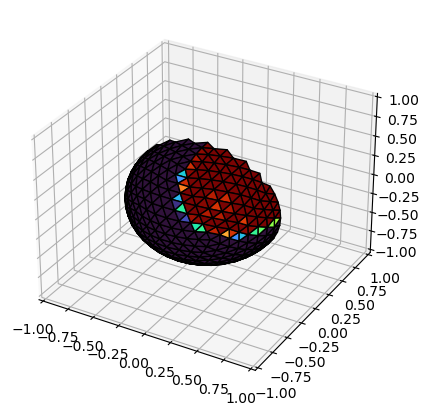

In [16]:
from mpl_toolkits.mplot3d import Axes3D, art3d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
c=jnp.clip(jnp.sum(occluded, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1)
# c=jnp.clip(jnp.sum(a, axis=1)/projected_areas(vs1[:, :, 0], vs1[:, :, 2]), 0, 1)
n = plt.Normalize(np.min(c), np.max(c))

pc = art3d.Poly3DCollection(vs1, facecolors=plt.cm.turbo(n(c)), edgecolor="black")
ax.add_collection(pc)
ax.set_xlim(-1e11, 1e11)
ax.set_ylim(-1e11, 1e11)
ax.set_zlim(-1e11, 1e11)